In [1]:
%run db2.jupyter.ipynb

Pixiedust database opened successfully


DB2 Extensions Loaded.


In [2]:
#%sql CONNECT TO dsxdemo USER db2inst1 USING ? HOST 9.30.253.63 PORT 50002
%sql CONNECT TO test213 USER db2inst1 USING ? HOST 9.30.253.63 PORT 50002

Password [password]: ········
Connection successful.


In [11]:
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.graphics.api import qqplot

# Select data 04-19 to 04-24 to build Time Series model
df_predict = %sql SELECT date(COLLECTED) as DATE, hour(COLLECTED) as HOUR, decimal(round(avg(decimal(TOTAL_LOG_USED, 17, 2)) / 1024, 2), 17, 2) as TOTAL_LOG_USED_AVG_KB, decimal(round(max(decimal(TOTAL_LOG_USED, 17, 2)) / 1024, 2), 17, 2) as TOTAL_LOG_USED_MAX_KB, decimal(round(avg(decimal(TOTAL_LOG_AVAILABLE, 17, 2)) / 1024, 2), 17, 2) as TOTAL_LOG_AVAILABLE_AVG_KB, decimal(round(max(decimal(TOTAL_LOG_AVAILABLE, 17, 2)) / 1024, 2), 17, 2) as TOTAL_LOG_AVAILABLE_MAX_KB, decimal(round(avg(PCENTACTIVELOGUSED), 2), 17, 2) as ACTIVE_LOG_USED_PERCENT_AVG, decimal(round(max(PCENTACTIVELOGUSED), 2), 17, 2) as ACTIVE_LOG_USED_PERCENT_MAX, decimal(round(avg(decimal(TOT_LOG_USED_TOP, 17, 2)) / 1024, 2), 17, 2) as TOT_LOG_USED_TOP_AVG_KB, decimal(round(max(decimal(TOT_LOG_USED_TOP, 17, 2)) / 1024, 2), 17, 2) as TOT_LOG_USED_TOP_MAX_KB, decimal(round(avg(decimal(SEC_LOG_USED_TOP, 17, 2))/1024, 2), 17, 2) as SEC_LOG_USED_TOP_AVG_KB, decimal(round(max(decimal(SEC_LOG_USED_TOP, 17, 2)) / 1024, 2), 17, 2) as SEC_LOG_USED_TOP_MAX_KB, avg(SEC_LOGS_ALLOCATED) as SEC_LOGS_ALLOCATED_AVG, max(SEC_LOGS_ALLOCATED) as SEC_LOGS_ALLOCATED_MAX from IBM_DSM_VIEWS.MON_GET_TRANSACTION_LOG where dbconn_id='repo215' and date(collected) >= '2018-04-19' and date(collected) < '2018-04-24' group by date(COLLECTED), hour(COLLECTED) order by DATE, HOUR

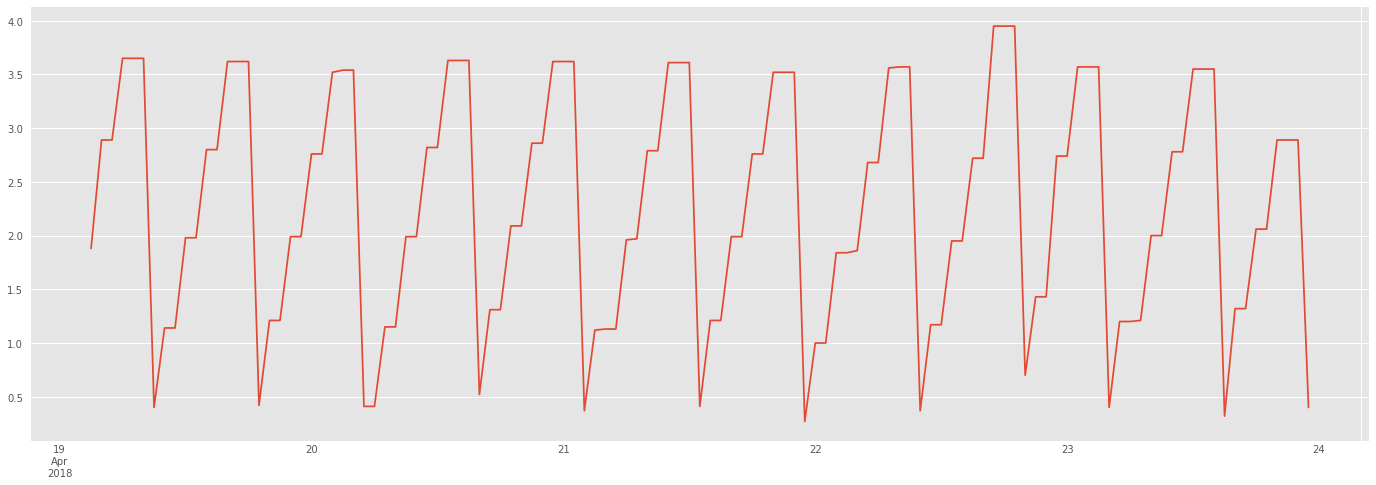

In [12]:
##################
## Build basic model
##################

x_date = df_predict['DATE'].values
x_hour = df_predict['HOUR'].values
x_date_list = list(x_date)
x_hour_list = list(x_hour)
ts_list = []
for i in range(len(x_hour_list)):
    hr_str = str(x_hour_list[i])
    if len(hr_str) == 1:
        hr_str = '0' + hr_str
    dt_str = str(x_date_list[i]) + ' ' + hr_str
    ts_list.append(dt_str)

y_max_log_percent = df_predict['ACTIVE_LOG_USED_PERCENT_MAX'].values
df_max = pd.Series(y_max_log_percent)
#df_max.index = pd.Index(ts_list)
df_max.index = pd.PeriodIndex(start = ts_list[0], end = ts_list[len(ts_list) - 1])
df_max.plot(figsize=(24,8))

plt.show()

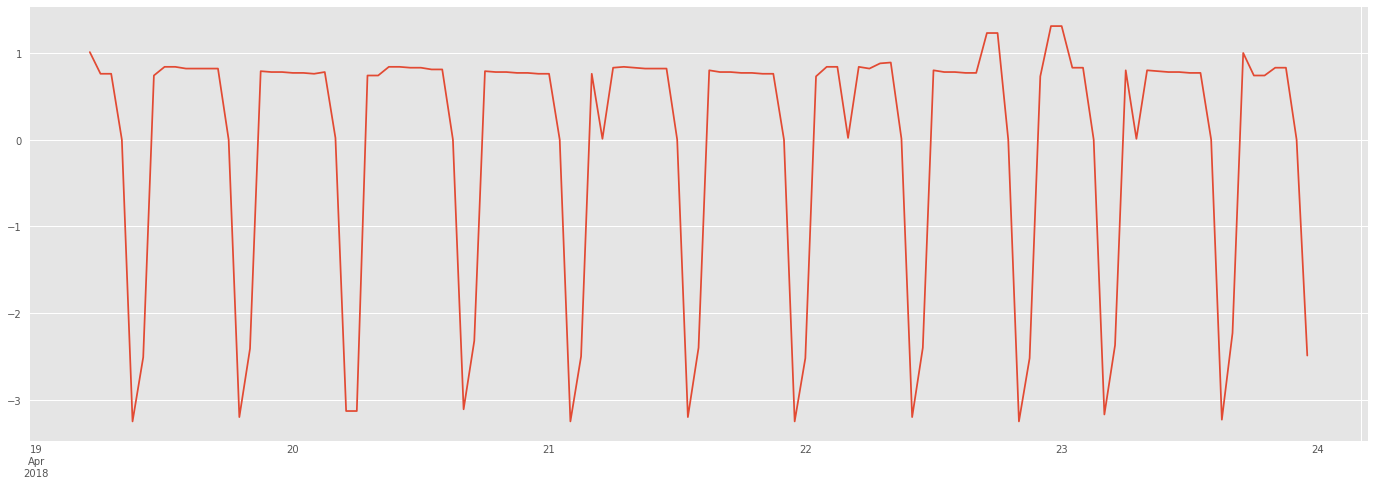

In [13]:
##################
## There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. 
##  * p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. 
##      Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
##  * d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing 
##      (i.e. the number of past time points to subtract from the current value) to apply to the time series.  
##      Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
##  * q is the moving average part of the model. 
##      This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
#################

##################
## Stationay is a requirement of ARIMA time series model. 
## The first thing for a non-stationary time series is to do Difference for time series until a stable time series is obtained. 
## If you do D times Difference for time series to get a stationary sequence, you can use the ARIMA (P, D, q) model, where D is the times of Difference.
##################

fig = plt.figure(figsize=(24,8))
ax1= fig.add_subplot(111)
diff1 = df_max.diff(2)
diff1.plot(ax=ax1)

In [ ]:
##################
## Choose proper p, q to build ARIMA model
## Check autocorrelation(ACF) and partial autocorrelation(PACF) diagram of stationary time series
##################

diff1= df_max.diff(1)
fig = plt.figure(figsize=(24,8))

ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_max,lags=40,ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_max,lags=40,ax=ax2)
 
## Base on ACF and PACF, we can guess the value for (p,q) which can be used to build ARIMA model

In [14]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

arma_mod70 = sm.tsa.ARMA(df_max,(7,0)).fit()
print(arma_mod70.aic,arma_mod70.bic,arma_mod70.hqic)
arma_mod30 = sm.tsa.ARMA(df_max,(0,1)).fit()
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)
arma_mod71 = sm.tsa.ARMA(df_max,(7,1)).fit()
print(arma_mod71.aic,arma_mod71.bic,arma_mod71.hqic)
arma_mod80 = sm.tsa.ARMA(df_max,(8,0)).fit()
print(arma_mod80.aic,arma_mod80.bic,arma_mod80.hqic)

resid = arma_mod70.resid

## From the result, we can see (7,0) is the best fitting

280.001427108 304.8609925214746 290.09410402183846
338.703212754 346.9897345584951 342.06743839194974
280.41485123 308.03659057765265 291.62893668916803
280.307363896 307.9291032438484 291.52144935536376


In [ ]:
## Check Residual sequence

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.show()

NormaltestResult(statistic=11.718262436666887, pvalue=0.002853721867262823)


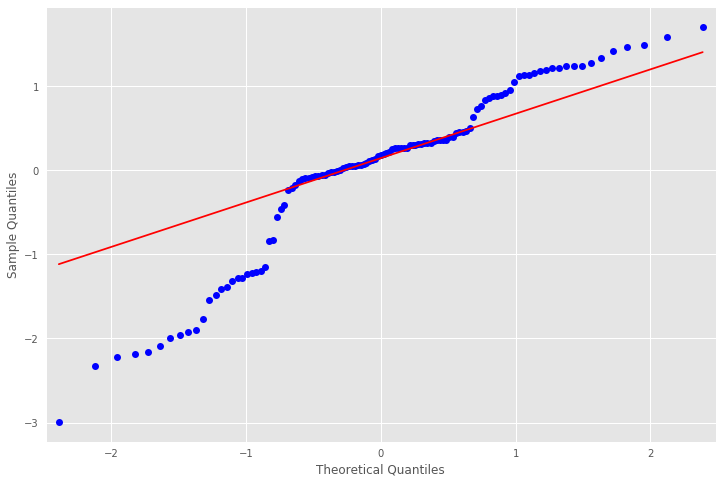

In [48]:
## Inspect whether the data consistent with normal distribution

print(stats.normaltest(resid))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

## The results show that the data consistent with normal distribution

2018-04-24 00:00    2.317750
2018-04-24 01:00    1.940888
2018-04-24 02:00    2.273523
2018-04-24 03:00    1.669880
2018-04-24 04:00    2.657126
2018-04-24 05:00    2.431624
2018-04-24 06:00    3.164891
2018-04-24 07:00    2.703197
2018-04-24 08:00    2.465590
2018-04-24 09:00    1.644134
2018-04-24 10:00    1.849129
2018-04-24 11:00    1.819147
2018-04-24 12:00    2.211208
2018-04-24 13:00    2.144764
2018-04-24 14:00    2.401966
2018-04-24 15:00    2.448672
2018-04-24 16:00    2.763098
2018-04-24 17:00    2.657790
2018-04-24 18:00    2.469712
2018-04-24 19:00    2.017001
2018-04-24 20:00    1.876056
2018-04-24 21:00    1.857309
2018-04-24 22:00    2.098091
2018-04-24 23:00    2.230129
2018-04-25 00:00    2.388321
2018-04-25 01:00    2.449182
2018-04-25 02:00    2.569297
2018-04-25 03:00    2.552650
2018-04-25 04:00    2.441368
2018-04-25 05:00    2.181116
2018-04-25 06:00    1.996716
2018-04-25 07:00    1.933235
2018-04-25 08:00    2.055996
2018-04-25 09:00    2.213731
2018-04-25 10:

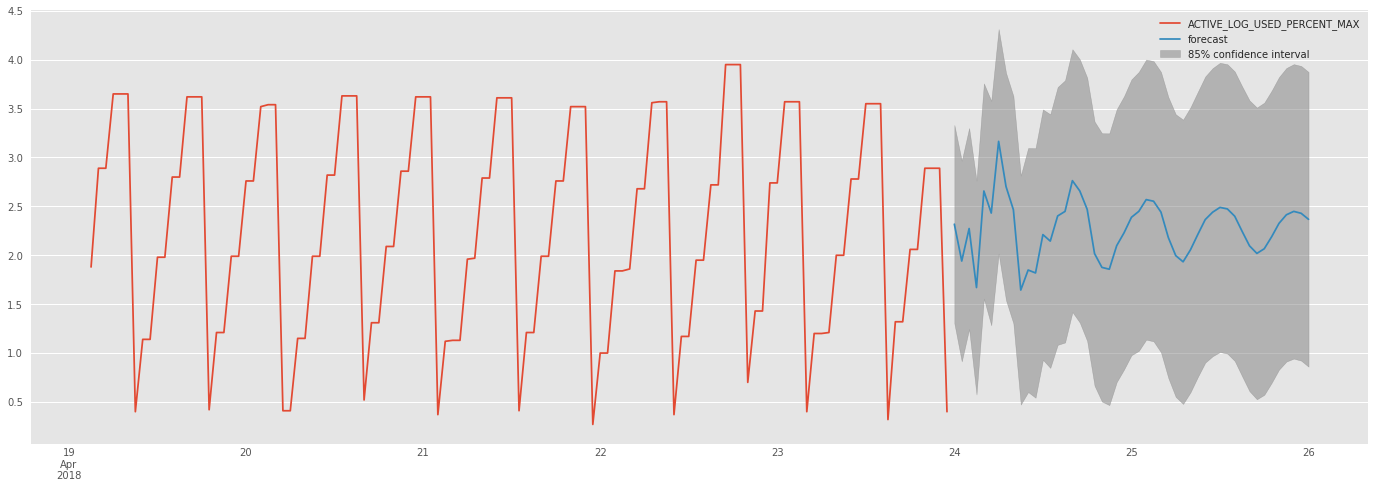

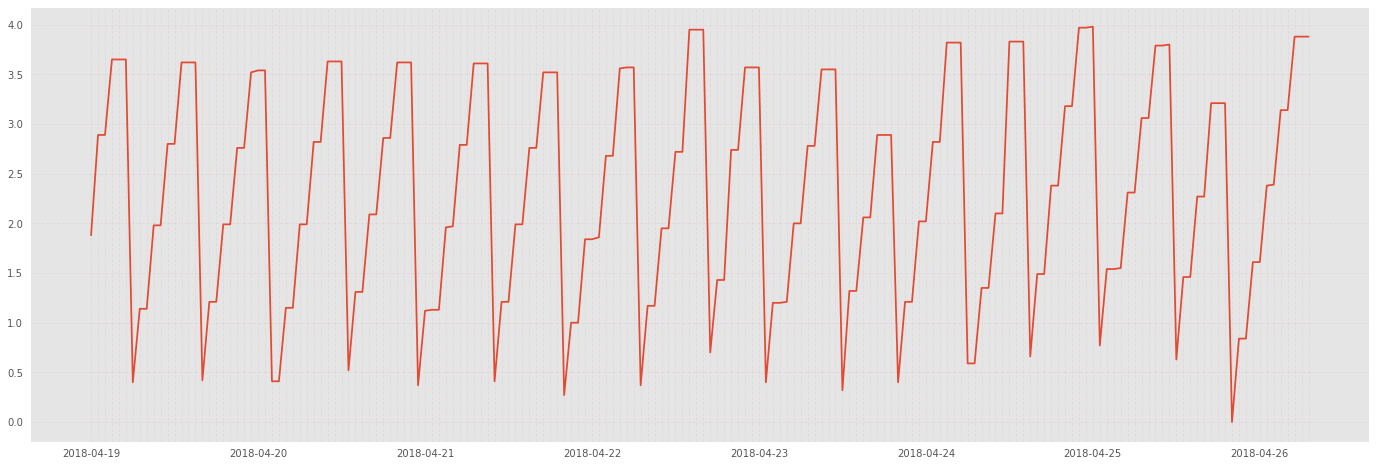

In [35]:
## Predict
arma_mod720 = sm.tsa.ARMA(df_max,(7,2,0)).fit()
predict_dta = arma_mod720.predict('2018-04-24 01', '2018-04-26 00', dynamic=True)
pd.options.display.max_rows = 999
print(predict_dta)

fig, ax = plt.subplots(figsize=(24, 8))
#ax = df_max.loc[x_date].plot(ax=ax)
ax = df_max.loc['2018-04-19':].plot(ax=ax, label='ACTIVE_LOG_USED_PERCENT_MAX')
#ax = df_max.ix['2018-04-21':].plot(ax=ax)
fig = arma_mod720.plot_predict('2018-04-24 01', '2018-04-26 00', dynamic=True, ax=ax, plot_insample=False, alpha = 0.15)

plt.show()

# Select data before 04-26 for comparison
df_real = %sql SELECT date(COLLECTED) as DATE, hour(COLLECTED) as HOUR, decimal(round(avg(decimal(TOTAL_LOG_USED, 17, 2)) / 1024, 2), 17, 2) as TOTAL_LOG_USED_AVG_KB, decimal(round(max(decimal(TOTAL_LOG_USED, 17, 2)) / 1024, 2), 17, 2) as TOTAL_LOG_USED_MAX_KB, decimal(round(avg(decimal(TOTAL_LOG_AVAILABLE, 17, 2)) / 1024, 2), 17, 2) as TOTAL_LOG_AVAILABLE_AVG_KB, decimal(round(max(decimal(TOTAL_LOG_AVAILABLE, 17, 2)) / 1024, 2), 17, 2) as TOTAL_LOG_AVAILABLE_MAX_KB, decimal(round(avg(PCENTACTIVELOGUSED), 2), 17, 2) as ACTIVE_LOG_USED_PERCENT_AVG, decimal(round(max(PCENTACTIVELOGUSED), 2), 17, 2) as ACTIVE_LOG_USED_PERCENT_MAX, decimal(round(avg(decimal(TOT_LOG_USED_TOP, 17, 2)) / 1024, 2), 17, 2) as TOT_LOG_USED_TOP_AVG_KB, decimal(round(max(decimal(TOT_LOG_USED_TOP, 17, 2)) / 1024, 2), 17, 2) as TOT_LOG_USED_TOP_MAX_KB, decimal(round(avg(decimal(SEC_LOG_USED_TOP, 17, 2))/1024, 2), 17, 2) as SEC_LOG_USED_TOP_AVG_KB, decimal(round(max(decimal(SEC_LOG_USED_TOP, 17, 2)) / 1024, 2), 17, 2) as SEC_LOG_USED_TOP_MAX_KB, avg(SEC_LOGS_ALLOCATED) as SEC_LOGS_ALLOCATED_AVG, max(SEC_LOGS_ALLOCATED) as SEC_LOGS_ALLOCATED_MAX from IBM_DSM_VIEWS.MON_GET_TRANSACTION_LOG where dbconn_id='repo215' and date(collected) >= '2018-04-19' group by date(COLLECTED), hour(COLLECTED) order by DATE, HOUR
df_real.head()

x_date_real = df_real['DATE'].values
x_hour_real = df_real['HOUR'].values
x_date_real_list = list(x_date_real)
x_hour_real_list = list(x_hour_real)

x_list=[]
x_ticks = []

plt.subplots(figsize=(24, 8))
plt.grid(True,ls='--',color='#a6266e',alpha =0.05)

for i_real in range(len(x_hour_real_list)):
    x_ticks.append(i_real)
    dt_str_real = str(str(x_date_real_list[i_real]))
    if i_real % 24 == 0:
        x_list.append(dt_str_real)
    else:
        x_list.append('')

y_max_log_percent_real = df_real['ACTIVE_LOG_USED_PERCENT_MAX'].values
y_list = list(y_max_log_percent_real)

plt.xticks(x_ticks, x_list, rotation = 0)

plt.plot(x_ticks, y_list)
plt.show()